## This notebook analyzes data for pricing optimization from an A/B test. 

### Three main questions are addressed:
1) At which price should the company list their software? <br>
2) What attributes of customer behavior influence conversion rate? <br>
3) How long should the experiment have taken? <br>

### The results are summarized below:
1) The company had a higher conversion rate for lower priced software. However, the difference <br> in conversion rates did not outweigh the revenue generated by the higher priced software. <br> Therefore, the company should list their software at a higher price.<br>
<br>
2) The top three sources of the highest conversion rates were: 1) Friend Referral,  2) Seo-bing, 3) Ads-google. <br>
The company could invest more in these domains given that they work <br> and eliminate sources with low conversion rates, or rethink the strategy for sources <br> with low conversion rates.
<br>
<br> 3) Based on a power analysis, the experiment could have been conducted in 5 days with 34,578 users.

In [2]:
# import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [3]:
# change the directory to where the data files are stored
path = "/Users/camilletoarmino/Google Drive/Insight Data Science /data_challenges/data_challenge_2"
os.chdir(path)

In [4]:
# read in data
test_results = pd.read_csv("test_results.csv")
user_table = pd.read_csv("user_table.csv")

### Check data for any abnormalities or missing values

In [5]:
# look at data
test_results = test_results.drop("Unnamed: 0", axis=1)
test_results.head()

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39.0,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39.0,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39.0,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59.0,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39.0,0


In [6]:
user_table.head()

,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68


In [7]:
# look at data types for test results
test_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316800 entries, 0 to 316799
Data columns (total 8 columns):
user_id             316800 non-null int64
timestamp           316466 non-null object
source              316488 non-null object
device              316800 non-null object
operative_system    296461 non-null object
test                316800 non-null int64
price               316800 non-null float64
converted           316800 non-null int64
dtypes: float64(1), int64(3), object(4)
memory usage: 19.3+ MB


Note that we are missing some timestamp, source, and operating system data.

In [8]:
# number of null values
print("timestamp null values is", test_results.timestamp.isnull().sum())
print("source null values is", test_results.source.isnull().sum())
print("OS null values is", test_results.operative_system.isnull().sum())

timestamp null values is 334
source null values is 312
OS null values is 20339


In [9]:
# look at data types for user table
user_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275616 entries, 0 to 275615
Data columns (total 5 columns):
user_id    275616 non-null int64
city       275616 non-null object
country    275616 non-null object
lat        275616 non-null float64
long       275616 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 10.5+ MB


All data is present for the user table, but there is a mismatch between the number of <br>
users in this table and the number of users in test results. More users in the test <br>
results table.

In [10]:
# are there duplicate users in the test results table? --- No, just more users 
print("Number of unique user ids is:", test_results.user_id.nunique())

Number of unique user ids is: 316800


So, not every user from test results will have user info in the user table.

In [11]:
# The number of unique values for price should be 2, but getting 3000+
test_results.price.nunique()

3076

In [12]:
# Choosing to drop the price column to avoid confusion and just use test column 
# which contains this information
test_results = test_results.drop("price", axis=1)

In [30]:
test_results.iloc(0,"user_id")

TypeError: __call__() takes from 1 to 2 positional arguments but 3 were given

### Exploratory Data Analysis

Let’s take a look at how many users converted in each group (39 and  59)

In [15]:
# examine number of converteds for each test group
a = test_results.groupby(["test"])["user_id"].count()

In [22]:
a = a.reset_index()
a

,index,test,user_id
0,0,0,202727
1,1,1,114073


In [35]:
# for each group, what proportion bought the software? this is the conversion rate
print("The percent of users that saw $39 and bought software is:", round(a[0][1]/(a[0][0]+a[0][1])*100,1))
print("The percent of users that saw $59 and bought software is:", round(a[1][1]/(a[1][0]+a[1][1])*100,1))

The percent of users that saw $39 and bought software is: 2.0
The percent of users that saw $59 and bought software is: 1.6


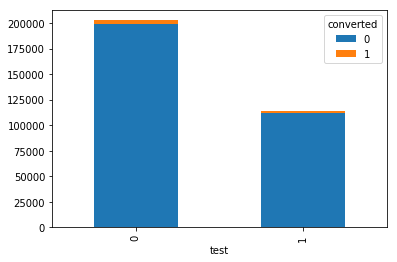

In [95]:
a_plt = test_results.groupby(["test","converted"])["test"].count().unstack('converted')
a_plt[[0,1]].plot(kind='bar', stacked=True);

The less expensive software is more likely to sell, but this might not matter when considering the difference in revenue. <br>

In [37]:
# how much money is made? estimated revenue per 1000 users
print("estimated revenue made by $39:", 39*20) #20=2%
print("estimated revenue made by $59:", 59*16) #16=1.6%

estimated revenue made by $39: 780
estimated revenue made by $59: 944


In [110]:
res = test_results.groupby(["test","converted"])["test"].count()
res

test  converted
0     0            198692
      1              4035
1     0            112300
      1              1773
Name: test, dtype: int64

In [193]:
# This uses a simple normal test for proportions. It should be the
# same as running the mean z-test on the data encoded 
# 1 for event and 0 for no event so that the sum corresponds to the count.

from statsmodels.stats.proportion import proportions_ztest

count = np.array([res[0][1],res[1][1]])
nobs = np.array([198692+4035,112300+1773])
value = .05
stat, pval = proportions_ztest(count, nobs, value)
print(pval)
print("statistically significant")

0.0
statistically significant


Even though less users buy the software at a higher price, there is still more revenue <br>
overall at the higher price, so should sell at $59. There is a significant difference in <br>
conversion rates found via a z-test.

### User Insights

In [38]:
# merge user table with results tables
merged_df = pd.merge(test_results, user_table, on="user_id", how="left")

In [39]:
merged_df.describe(include="all")

,user_id,timestamp,source,device,operative_system,test,converted,city,country,lat,long
count,316800.000000,316466,316488,316800,296461,316800.000000,316800.000000,275616,275616,275616.000000,275616.000000
unique,NaN,141147,12,2,8,NaN,NaN,923,1,NaN,NaN
top,NaN,2015-04-12 11:51:16,direct_traffic,mobile,windows,NaN,NaN,New York,USA,NaN,NaN
freq,NaN,12,60307,186471,100878,NaN,NaN,25748,275616,NaN,NaN
mean,499281.341840,NaN,NaN,NaN,NaN,0.360079,0.018333,NaN,NaN,37.111680,-93.981772
std,288591.154044,NaN,NaN,NaN,NaN,0.480024,0.134154,NaN,NaN,5.209627,18.086486
min,3.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,19.700000,-157.800000
25%,249525.750000,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,33.660000,-112.200000
50%,499021.500000,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,37.740000,-88.930000
75%,749025.500000,NaN,NaN,NaN,NaN,1.000000,0.000000,NaN,NaN,40.700000,-78.910000


Why are there 8 instances of operative system?

In [40]:
merged_df.operative_system.value_counts()

windows    100878
iOS         95352
android     74856
mac         25056
i0S           113
wnddows        98
anroid         79
apple          29
Name: operative_system, dtype: int64

Because windows, iOs, apple, and android are entered improperly. Time to clean up.

In [41]:
merged_df["operative_system"] = merged_df.operative_system.replace({"i0S": "iOS", "wnddows": "windows",
                                   "anroid":"android", "apple":"mac"})
merged_df.operative_system.value_counts()

windows    100976
iOS         95465
android     74935
mac         25085
Name: operative_system, dtype: int64

In [42]:
# just select meaningful columns for analysis
cols = ["user_id", "timestamp", "source", "device", "operative_system", "test", "converted", "city"]
merged_df = merged_df[cols]

In [43]:
merged_df.head()

,user_id,timestamp,source,device,operative_system,test,converted,city
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,0,Buffalo
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,0,Lakeville
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,0,Parma
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,0,Fayetteville
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,0,Fishers


What was the conversion rate for each source?

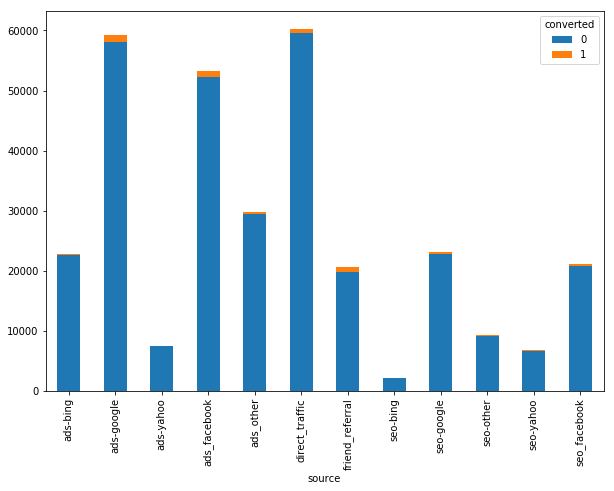

In [58]:
source_plt = merged_df.groupby(["source","converted"])["user_id"].count().unstack('converted')
source_plt[[0,1]].plot(kind='bar', stacked=True, figsize=(10,7));

In [79]:
# for each group, what proportion bought the software? this is the conversion rate/source
b = merged_df.groupby(["source","converted"])["user_id"].count()

In [80]:
# calculate conversion rate for each source
ads_bing = round(b["ads-bing"][1]/(b["ads-bing"][1]+b["ads-bing"][0])*100,1)
ads_google = round(b["ads-google"][1]/(b["ads-google"][1]+b["ads-google"][0])*100,1)
ads_yahoo = round(b["ads-yahoo"][1]/(b["ads-yahoo"][1]+b["ads-yahoo"][0])*100,1)
ads_facebook = round(b["ads_facebook"][1]/(b["ads_facebook"][1]+b["ads_facebook"][0])*100,1)
ads_other = round(b["ads_other"][1]/(b["ads_other"][1]+b["ads_other"][0])*100,1)

direct_traffic = round(b["direct_traffic"][1]/(b["direct_traffic"][1]+b["direct_traffic"][0])*100,1)
friend = round(b["friend_referral"][1]/(b["friend_referral"][1]+b["friend_referral"][0])*100,1)

seo_bing = round(b["seo-bing"][1]/(b["seo-bing"][1]+b["seo-bing"][0])*100,1)
seo_google = round(b["seo-google"][1]/(b["seo-google"][1]+b["seo-google"][0])*100,1)
seo_other = round(b["seo-other"][1]/(b["seo-other"][1]+b["seo-other"][0])*100,1)
seo_yahoo = round(b["seo-yahoo"][1]/(b["seo-yahoo"][1]+b["seo-yahoo"][0])*100,1)
seo_facebook = round(b["seo_facebook"][1]/(b["seo_facebook"][1]+b["seo_facebook"][0])*100,1)

In [81]:
# display conversion rate for each source
print("Ads-bing conversion rate is:", ads_bing)
print("Ads-google conversion rate is:", ads_google)
print("Ads-yahoo conversion rate is:", ads_yahoo)
print("Ads-facebook conversion rate is:", ads_facebook)
print("Ads-other conversion rate is:", ads_other)
print("Direct traffic conversion rate is:", direct_traffic)
print("Friend referral conversion rate is:", friend)
print("Seo-bing conversion rate is:", seo_bing)
print("Seo-google conversion rate is:", seo_google)
print("Seo-other conversion rate is:", seo_other)
print("Seo-yahoo conversion rate is:", seo_yahoo)
print("Seo-facebook conversion rate is:", seo_facebook)

Ads-bing conversion rate is: 1.2
Ads-google conversion rate is: 2.2
Ads-yahoo conversion rate is: 1.5
Ads-facebook conversion rate is: 2.1
Ads-other conversion rate is: 1.4
Direct traffic conversion rate is: 1.2
Friend referral conversion rate is: 3.9
Seo-bing conversion rate is: 2.4
Seo-google conversion rate is: 1.7
Seo-other conversion rate is: 1.6
Seo-yahoo conversion rate is: 1.6
Seo-facebook conversion rate is: 1.6


The top three highest conversion rates are: 1) Friend Referral, 2) Seo-bing, 3) Ads-google

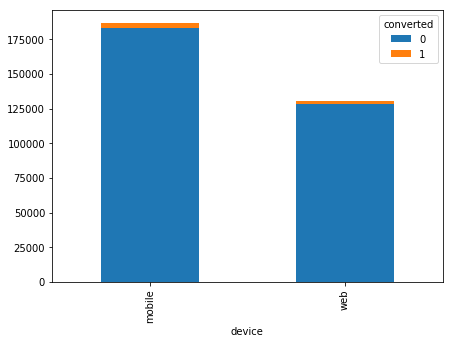

In [98]:
# for each device, what proportion bought the software? this is the conversion rate/device
device_plt = merged_df.groupby(["device","converted"])["user_id"].count().unstack('converted')
device_plt[[0,1]].plot(kind='bar', stacked=True, figsize=(7,5));

In [91]:
c = merged_df.groupby(["device","converted"])["user_id"].count()

In [92]:
# calculate conversion rate for device
mobile = round(c["mobile"][1]/(c["mobile"][1]+c["mobile"][0])*100,1)
web = round(c["web"][1]/(c["web"][1]+c["web"][0])*100,1)

In [94]:
# display conversion rate for each device
print("Mobile conversion rate is:", mobile)
print("Web conversion rate is:", web)

Mobile conversion rate is: 1.9
Web conversion rate is: 1.8


Although the site is frequented much more often on mobile devices, there is not much difference in <br>
the conversion rate between them.

What kind of operating system are users using?

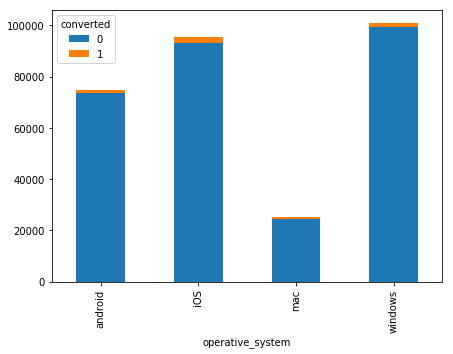

In [99]:
# for each os, what proportion bought the software? this is the conversion rate/os
os_plt = merged_df.groupby(["operative_system","converted"])["user_id"].count().unstack('converted')
os_plt[[0,1]].plot(kind='bar', stacked=True, figsize=(7,5));

In [100]:
d = merged_df.groupby(["operative_system","converted"])["user_id"].count()

In [102]:
# calculate conversion rate for device
android = round(d["android"][1]/(d["android"][1]+d["android"][0])*100,1)
ios = round(d["iOS"][1]/(d["iOS"][1]+d["iOS"][0])*100,1)
mac = round(d["mac"][1]/(d["mac"][1]+d["mac"][0])*100,1)
windows = round(d["windows"][1]/(d["windows"][1]+d["windows"][0])*100,1)

In [103]:
# display conversion rate for each device
print("Android conversion rate is:", android)
print("iOS conversion rate is:", ios)
print("Mac conversion rate is:", mac)
print("Windows conversion rate is:", windows)

Android conversion rate is: 1.5
iOS conversion rate is: 2.2
Mac conversion rate is: 2.4
Windows conversion rate is: 1.7


iOS and mac seem quite a bit higher, why? could target windows and android users more

### How long should the test have been run for to achieve statistically significant results?

This likely depends on how many users were visiting the site each day - power analysis, sample size estimation. <br>
First calculate the sample size needed:

In [192]:
import statsmodels.stats.api as sms

# effect size for a test comparing two proportions
es = sms.proportion_effectsize(0.016, 0.02)

# solve for sample size parameter of the power of a two sample z-test
sample_ = sms.NormalIndPower().solve_power(es, power=0.8, alpha=0.05, ratio=1)
print("Need a sample size per group of:", round(sample_,0))
print("Need total user sample of:", round(sample_,0)*2)

Need a sample size per group of: 17289.0
Need total user sample of: 34578.0


Now calculate the number of users per day to estimate the total number of days needed

In [162]:
# clean
merged_df['timestamp'] = merged_df.apply(lambda x: x.timestamp.replace(x.timestamp[1],'0'), axis=1)
# only keep the date - easier way?
merged_df['timestamp'] = merged_df.apply(lambda x: x.timestamp[0:10], axis=1)

In [164]:
# change to datetime
merged_df["timestamp"] = pd.to_datetime(merged_df.timestamp,format="%Y-%m-%d %H:%M:%S",errors='coerce')

In [185]:
# now calculate users per days
t = merged_df.set_index("timestamp")
users_per_day = t.groupby('timestamp').user_id.count().mean()
print("Average users per day:", round(users_per_day,2))

Average users per day: 3477.38


In [177]:
print("Total time needed for experiment is:", round(sample_/users_per_day,2), "days")

Total time needed for experiment is: 4.97 days


The total time needed for the experiment is 5 days.